# Artificial Intelligence and Machine Learning project work on recommendation systems

## Group
The group is composed by three second year Management and Computer Science students: Maria Chiara Lischi, Gabriele Pacielli, Matteo Spadaccia.

In [2]:
# IMPORTING PACKAGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import sys
import os
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## Exploratory Data Analysis

The goal of this Exploratory Data Analysis is to gain a deeper understanding of the dataset, which is composed of three .csv files containing information about the customers, the articles and the transactions involving a clothing store. It is useful to examine, analyze and prepare it for the further steps of this project, which aim to build different recommender systems. We are going to perform analysis in order to understand the characteristics of the dataset, identify patterns and relationships, and detect (and fix) any potential anomalies or issues, using techniques of data visualization, statistical analysis, and data transformation. 

### Importing, cleaning the dataset and computing minor statistics

As said, we want to import our dataset, which is divided into three .csv files. Using pandas library, we are importing it into three different DataFrames.

In [3]:
# SAVING THE FILES CONTAINING THE DATASET INTO PANDAS DATAFRAMES

art_df = pd.read_csv('Data/recsys_articles.csv') # dataframe containing information about the articles
cus_df = pd.read_csv('Data/recsys_customers.csv') # dataframe containing information about the customers
tra_df = pd.read_csv('Data/recsys_transactions.csv') # dataframe containing information about the transactions

At first, we want to get some insights about the articles dataset: it contains information about 6536 articles, for each of which we know the value of 21 different attributes (consultable below). Before proceding into deeper analysis, we want to clean the data getting rid of rows with invalid values (which appears under the form of "Unknown" and "undefined"). We won't investigate for particular correlations because it does not make sense doing so with this dataset taken alone, but we will group the data following different criteria. 

In [4]:
# GETTING INFORMATION ABOUT THE ARTICLES DATASET

# General information of the raw dataset
print('Overview of the articles dataset:')
display(art_df.head())

print('Relevant information about the raw articles dataset:')
display(art_df.info())

print('Shape of the raw articles dataset:')
display(art_df.shape)

# Looking for invalid values under the different attributes and dropping them
n_invalid = 0
total = len(art_df)
for column in art_df:
    n_invalid += len(art_df.loc[art_df[column] == 'Unknown'])
    n_invalid += len(art_df.loc[art_df[column] == 'undefined'])
    art_df = art_df[~art_df[column].isin(['Unknown', 'undefined'])]
    
# Checking for the percentage of invalid data with respect to the total
art_invalid_percentage = n_invalid/total*100
print('The percentage of invalid rows (containing undefined values) is: ' + str(art_invalid_percentage) + "%")

# Printing the new shape of the dataset
print('Shape of the cleaned articles dataset:')
display(art_df.shape)

Overview of the articles dataset:


,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights


Relevant information about the raw articles dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_id                    6536 non-null   int64 
 1   prod_name                     6536 non-null   object
 2   product_type                  6536 non-null   int64 
 3   product_type_name             6536 non-null   object
 4   product_group_name            6536 non-null   object
 5   colour_group                  6536 non-null   int64 
 6   colour_group_name             6536 non-null   object
 7   perceived_colour_value        6536 non-null   int64 
 8   perceived_colour_value_name   6536 non-null   object
 9   perceived_colour_master       6536 non-null   int64 
 10  perceived_colour_master_name  6536 non-null   object
 11  department                    6536 non-null   int64 
 12  department_name        

None

Shape of the raw articles dataset:


(6536, 21)

The percentage of invalid rows (containing undefined values) is: 3.182374541003672%
Shape of the cleaned articles dataset:


(6328, 21)

We focus now on the customers dataset: it contains information about 41253 different customers. For each customer, we have data about their age, and whether or not they have a club membership or are subscribed to the fashion newsletter of the clothing shop. We clean the data by getting rid of rows with invalid values under the attribute "age" (which appear under the form of "null" values). We also want to compute some statistics about the age (in this case we are interested in the mean, standard deviation and main percentiles) and the "fashion_news" and "club_member" attributes (in the latter cases we are only interested in the mean, which represents the percentage of customers which, over the total, are respectivley subsribers to the fashion news and club members).

In [5]:
# GETTING INFORMATION ABOUT THE CUSTOMERS DATASET

# General information of the raw customers dataset
print('Overview of the customers dataset:')
display(cus_df.head())

print('Relevant information about the raw customers dataset:')
display(cus_df.info())

print('Shape of the raw customers dataset:')
display(cus_df.shape)

# Looking for invalid (in this case "null") values under the "age" attribute and dropping them
cus_df.isnull().sum()
age_null_percentage = cus_df['age'].isnull().sum()/len(cus_df)
cus_df = cus_df.dropna(axis = 'index')

# Checking for the percentage of invalid data with respect to the total
print('The percentage of null values under the "age" attribute is: ' + str(age_null_percentage))

# Exploring the quantitative characteristics of the cleaned dataset
print('Shape of the cleaned customers dataset:')
display(cus_df.shape)

print('Statistics of the cleaned customers dataset:') # here we want to focus on the ones of the "age" attribute
display(cus_df.describe())

# looking for correlations among club membership, fashion news subscriptions and age
print('Correlations under the cleaned customers dataset attributes:') 
cus_df.corr()

Overview of the customers dataset:


,customer_id,fashion_news,club_member,age
0,0,1,1,44.0
1,1,1,1,33.0
2,2,0,0,29.0
3,3,0,0,21.0
4,4,0,0,23.0


Relevant information about the raw customers dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41253 entries, 0 to 41252
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   41253 non-null  int64  
 1   fashion_news  41253 non-null  int64  
 2   club_member   41253 non-null  int64  
 3   age           41120 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.3 MB


None

Shape of the raw customers dataset:


(41253, 4)

The percentage of null values under the "age" attribute is: 0.0032240079509369014
Shape of the cleaned customers dataset:


(41120, 4)

Statistics of the cleaned customers dataset:


,customer_id,fashion_news,club_member,age
count,41120.000000,41120.000000,41120.000000,41120.000000
mean,20625.345136,0.442194,0.436406,35.320696
std,11907.896730,0.496653,0.495945,12.666097
min,0.000000,0.000000,0.000000,16.000000
25%,10314.750000,0.000000,0.000000,25.000000
50%,20626.500000,0.000000,0.000000,31.000000
75%,30936.250000,1.000000,1.000000,46.000000
max,41252.000000,1.000000,1.000000,91.000000


Correlations under the cleaned customers dataset attributes:


,customer_id,fashion_news,club_member,age
customer_id,1.000000,0.005685,0.005425,0.002554
fashion_news,0.005685,1.000000,0.988320,0.063100
club_member,0.005425,0.988320,1.000000,0.065650
age,0.002554,0.063100,0.065650,1.000000


The last dataset is the transactions dataset, which contains informations about 369113 transactions; specifically the date in which the transaction happened, the costumer who made it and the article that was bought are known. We also checked for invalid values, which do not seems to appear.

In [6]:
# GETTING INFORMATION ABOUT THE TRANSACTION DATASET

# General information of the transaction dataset
print('Overview of the transaction dataset:')
display(tra_df.head())

print('Relevant information about the transactions dataset:')
display(tra_df.info())

print('Shape of the transactions dataset:')
display(tra_df.shape)

print('Average transaction per single user: ', round(len(tra_df['article_id'])/tra_df['customer_id'].nunique()))
print('Average sell per single product: ', round(len(tra_df['article_id'])/tra_df['article_id'].nunique()))

# Looking for invalid values under the "age" attribute
print('Invalid values per attribute in the transactions dataset:')
tra_df.isnull().sum()

Overview of the transaction dataset:


,t_dat,customer_id,article_id
0,2020-09-02,7,599
1,2020-09-02,7,2600
2,2020-09-02,7,2063
3,2020-09-02,7,5188
4,2020-09-02,17,5111


Relevant information about the transactions dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369113 entries, 0 to 369112
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   t_dat        369113 non-null  object
 1   customer_id  369113 non-null  int64 
 2   article_id   369113 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.4+ MB


None

Shape of the transactions dataset:


(369113, 3)

Average transaction per single user:  9
Average sell per single product:  56
Invalid values per attribute in the transactions dataset:


t_dat          0
customer_id    0
article_id     0
dtype: int64

### Data visualization
Having now a good overview of how the dataset is built, its shape and its attributes, and having cleaned it, we proceed by investingating for more complex statistics of the data and providing some useful graphs, which can help us getting interesting insights about the data.

We start by considering the age distribution of the costumers, therefore, we plot the related histogram.

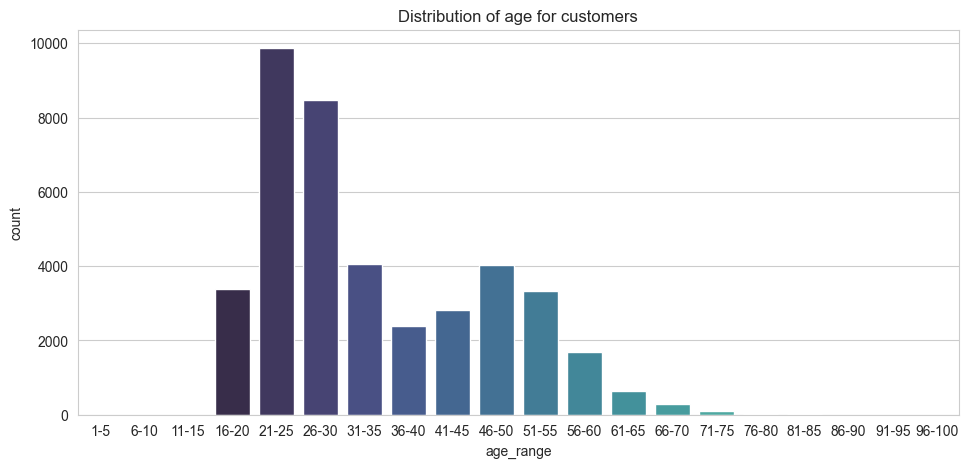

In [7]:
# AGE DISTRIBUTION AMONG CUSTOMERS

# Dividing costumers into age bins of five years
thresholds = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101]
ranges = ['1-5', '6-10','11-15', '16-20', '21-25', '26-30','31-35', '36-40','41-45', '46-50','51-55', '56-60','61-65', '66-70','71-75', '76-80','81-85', '86-90','91-95', '96-100']
cus_df['age_range'] = pd.cut(cus_df.age, thresholds, labels = ranges, include_lowest = True)

# Displaying the histogram
sns.set_style("whitegrid")
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'age_range', data = cus_df, palette = 'mako')
plt.title('Distribution of age for customers');

We want now to investigate the percentage of customers that are club members and subscribed to the fashion newsletter with respect to the total. We notice that the two pie charts looks very similar, coherently with what was we discovered before about the correlation of the two attributes, which is very high (circa .98)

Pie chart displaying the club members over the total number of customers:


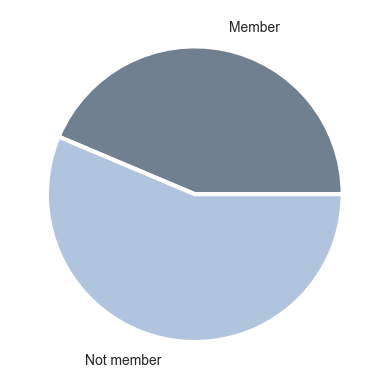

In [8]:
# CLUB MEMBERS / TOTAL CUSTOMERS

print('Pie chart displaying the club members over the total number of customers:')
_ = plt.figure()
plt.pie([cus_df['club_member'].value_counts()[1],cus_df['club_member'].value_counts()[0]], labels = ['Member','Not member'],  labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = ['slategrey','lightsteelblue'])
plt.show()

Pie chart displaying the subscribers to the fashion over the total number of customers:


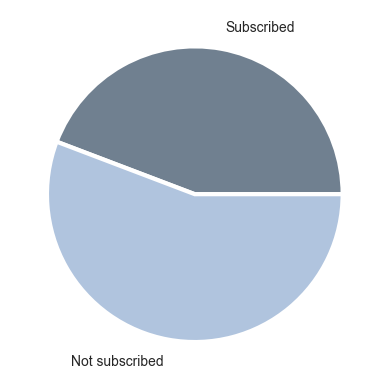

In [9]:
# FASHION NEWS SUBSCRIBERS / TOTAL CUSTOMERS

print('Pie chart displaying the subscribers to the fashion over the total number of customers:')
_ = plt.figure()
plt.pie([cus_df['fashion_news'].value_counts()[1],cus_df['fashion_news'].value_counts()[0]], labels = ['Subscribed','Not subscribed'],  labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = ['slategrey','lightsteelblue'])
plt.show()

For a more accurate analysis, we investigate for age-ranges in which customers are more likely to be part of the club and subscribe to the fashion news.

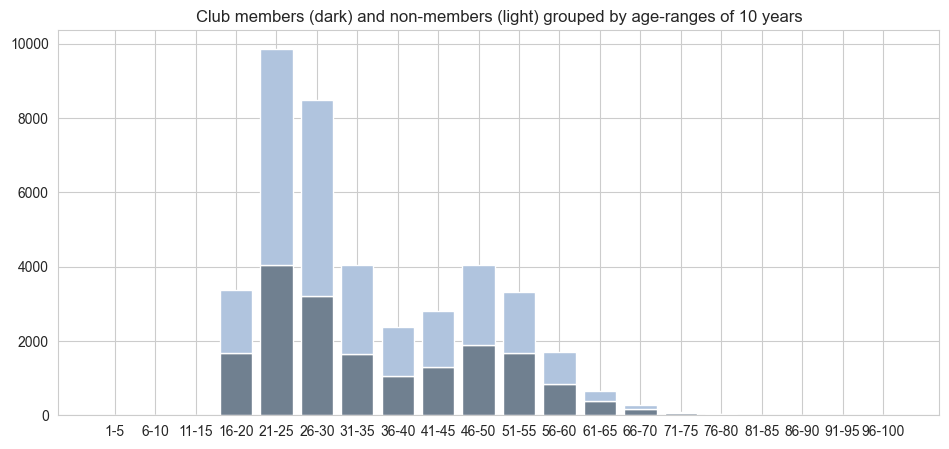

In [10]:
# MEMBERS (AND NOT) OF THE CLUB GROUPED BY AGE-RANGES OF 10 YEARS AND

# Dividing costumers into age bins of five years
age_ranges = cus_df.groupby('age_range').size()
age_ranges_df = pd.DataFrame([age_ranges]).T.reset_index()
age_ranges_df.columns = ['Age range', 'Count']

# Members (and not) of the club grouped by age-ranges of 10 years
members_by_age_df = cus_df.groupby(['age_range', 'club_member']).count().reset_index()
members_by_age_df = members_by_age_df.drop(columns = ['fashion_news', 'age'])
members_by_age_df.columns = ['age_group', 'club_member', 'count']

members = []  
non_members = []
for i in range(int(len(members_by_age_df)/2)):
    members.append(members_by_age_df.iloc[2*i+1,2])  
    non_members.append(members_by_age_df.iloc[2*i,2])
    
# Displaying the histogram
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
plt.bar(ranges, members, color = 'slategrey')
plt.bar(ranges, non_members, bottom = members, color = 'lightsteelblue')
plt.title('Club members (dark) and non-members (light) grouped by age-ranges of 10 years')
plt.show()   

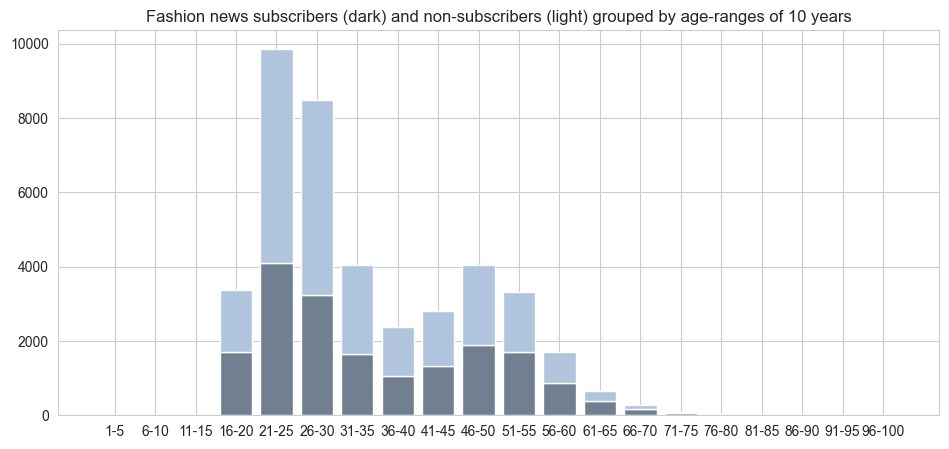

In [11]:
# FASHION NEWS SUBSCRIBERS (AND NOT) GROUPED BY AGE-RANGES OF 10 YEARS

# Fashion news subscribers (and not) grouped by age-ranges of 10 years
subscribers_by_age_df = cus_df.groupby(['age_range', 'fashion_news']).count().reset_index()
subscribers_by_age_df = subscribers_by_age_df.drop(columns = ['club_member', 'age'])
subscribers_by_age_df.columns = ['age_group', 'fashion_news', 'count']

subscribers = []  
non_subscribers = []
for i in range(int(len(subscribers_by_age_df)/2)):
    subscribers.append(subscribers_by_age_df.iloc[2*i+1,2])  
    non_subscribers.append(subscribers_by_age_df.iloc[2*i,2])

# Displaying the histogram
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
plt.bar(ranges, subscribers, color = 'slategrey')
plt.bar(ranges, non_subscribers, bottom = subscribers, color = 'lightsteelblue')
plt.title('Fashion news subscribers (dark) and non-subscribers (light) grouped by age-ranges of 10 years')
plt.show()  

We now focus focus on the average number of purchases made by each age-range ploting the related scatterplot

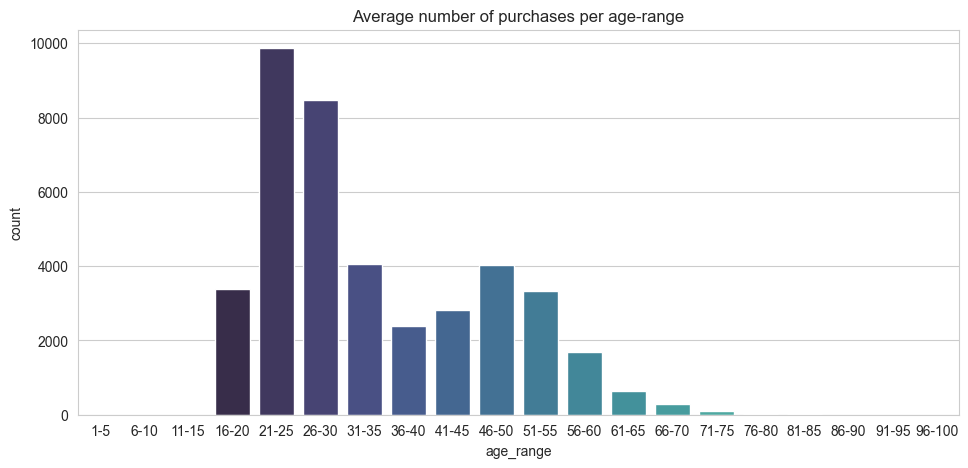

In [12]:
# AVERAGE NUMBER OF PURCHASES PER AGE

# Preparing the data for the visualization:
tra_by_cus_df = pd.DataFrame()
tra_by_cus_df['purchases'] = tra_df.groupby('customer_id').size()
tra_by_cus_df['age_range'] = cus_df['age_range']
tra_by_cus_df = tra_by_cus_df.dropna(axis = 'index')

tra_by_age_group_df = pd.DataFrame()
tra_by_age_group_df['purchases'] = tra_by_cus_df.groupby('age_range').mean()
tra_by_age_group_df = tra_by_age_group_df.dropna(axis = 'index')

# Displaying the histogram
sns.set_style("whitegrid")
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'age_range', data = cus_df, palette = 'mako')
plt.title('Average number of purchases per age-range');

a = ['product_type', 'colour_group', 'section', 'garment_group']
garment_group_name
perceived_colour_value_name


Let's now concentrate on the articles dataset. First we want to gain a better understanding of the attributes. To do so, we will investigate for the range of values each attribute can assume.

Merging this analysis with the information gained before about the dataset, we noticed that some pairs of attributes have the same span: this is because in the articles dataset there are pairs of attributes bringing the same information with the difference that one is in categorical value and the other is numerical. Below, the attributes listed pairwise (first numerical then categorical):
- product_type and product_type_name;
- colour_group and colour_group_name;
- perceived_colour_value and perceived_colour_value_name;
- perceived_colour_master and perceived_colour_master_name;
- index and index_name, index_group and index_group_name;
- section and section_name;
- garment_group and garment_group_name.

In [13]:
# COMPUTING THE RANGE OF VALUES OF EACH ATTRIBUTE FOR THE ARTICLES DATASET

r_o_v = {'attribute': [], 'range of values':[]}
for attribute in art_df:
    r_o_v['attribute'].append(attribute)
    r_o_v['range of values'].append(art_df[attribute].nunique())

range_of_values = pd.DataFrame.from_dict(r_o_v)
range_of_values.reset_index(drop = True, inplace = True)

print("Attributes of the article dataset with their range of values: ")
display(range_of_values)

Attributes of the article dataset with their range of values: 


,attribute,range of values
0,article_id,6328
1,prod_name,3581
2,product_type,80
3,product_type_name,80
4,product_group_name,11
5,colour_group,45
6,colour_group_name,45
7,perceived_colour_value,6
8,perceived_colour_value_name,6
9,perceived_colour_master,16


We want to know how the articles are distributes when grouped by different criteria. Since the information available on our dataset focuses on the colour and the group or type of articles, we decided to use the attributes 'colour_group_name' and 'garment_group_name' for the data visualization, which bring different information representative for their respective 'areas'. This is because these attributes with respect to the others bringing similar information (more and less detailed) are meaningful, easily interpretable and appear to have a range of values which is not too small nor too huge, allowing us to get a good visual ovierview of the distribution. 

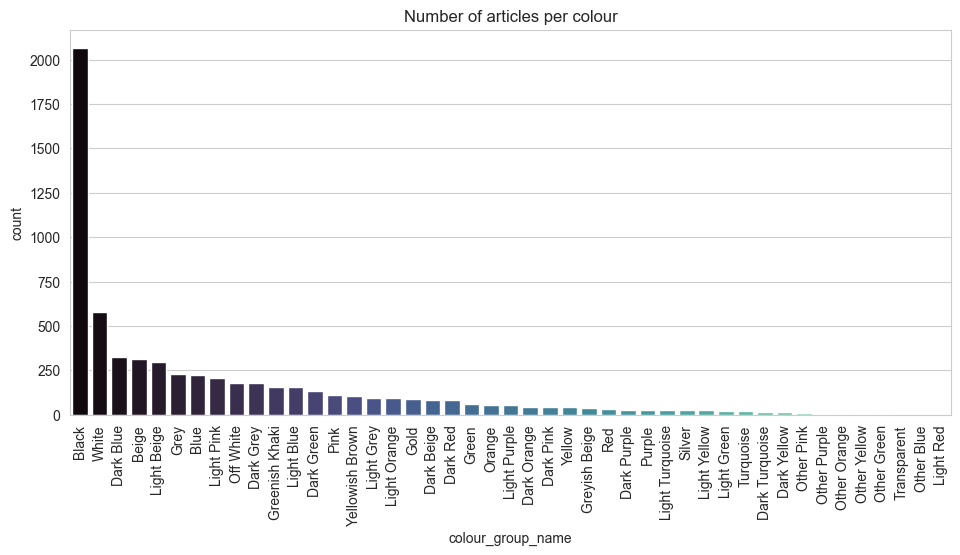

In [14]:
# ARTICLES GROUPED BY COLOUR GROUP

# Preparing the data for the visualization: sorting the groups in descending order
order = sorted(Counter(art_df['colour_group_name']).items(), key = lambda x:x[1], reverse = True)
order2 = [i[0] for i in order]

# Displaying the histogram
sns.set_style("whitegrid")
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'colour_group_name', data = art_df, palette = 'mako', order = order2)
plt.xticks(rotation = 90)
plt.title('Number of articles per colour');

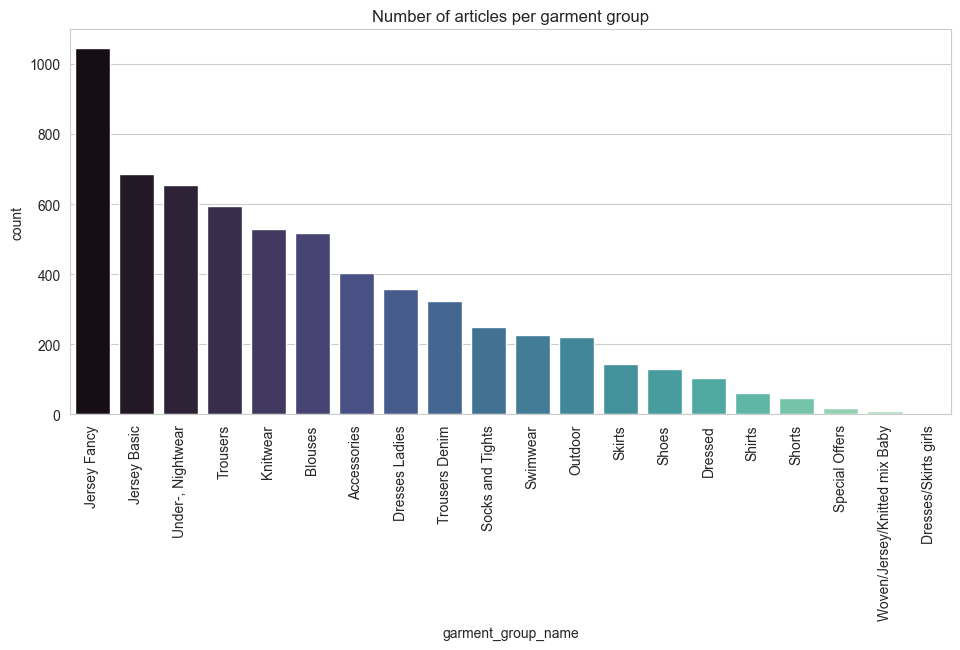

In [15]:
# ARTICLES GROUPED BY GARMENT GROUP

# Preparing the data for the visualization: sorting the groups in descending order
order = sorted(Counter(art_df['garment_group_name']).items(), key = lambda x:x[1], reverse = True)
order2 = [i[0] for i in order]

# Displaying the histogram
sns.set_style("whitegrid")
plt.figure(figsize = (25,5))
plt.subplot(1,2,1)
ax = sns.countplot(x = 'garment_group_name', data = art_df, palette = 'mako', order = order2)
plt.xticks(rotation = 90)
plt.title('Number of articles per garment group');

## Content-based recommender system

Now that we have a clear overview of the dataset, we want to build a content-based recommender system. The goal is to suggests new articles to a user basing on the user's past purchases. Therefore we want to suggest items that are similar to the ones we already know the user has a preference for.

Similarity is measured between articles by comparing the attributes of articles that a user has previously bought with the attributes of other articles. We are going to use the cosine distance to measure similarity, which is a typical choice for content-based recommender systems. Cosine similarity works by calculating the dot product of the vectors (rows representing attribute-values that each article has), measuring how similar the directions of the vectors. The higher the cosine similarity, the more similar the items are.

The attribute choice is extremely important since it determines the types of recommendations that the system is able to make: we want to exploit as many relevant information as possible, but we also don't want to use too many attributes, because this may make the recommendation process slow and cumbersome. In order to strike a balance, we choose the following attributes for the recommendation task:
- product_type;
- colour_group;
- section;
- garment_group;

This choice comes from the need of taking under consideration attributes which span in a relatively high range of values and contribute with different kind of information. Once determined the piece of information to consider, we decided to use the attribute containing the numerical value.

### Content-based recommender system (1)

In order to start building the content-based filtering recommender, we set up the dataset so that each row represent a different article and columns represent all the possible values that each of the attributes we considered can assume. To do so, we manipulate the columns representing the choosen attributes in the articles dataframe creating a new one (art_features_df). In this new dataframe each row contains a series of binary features: "1" indicates that the article falls under a given attribute value, while "0" indicates that it does not.

In [16]:
# IMPLEMENTING THE TABLE

features = ['product_type', 'colour_group', 'section', 'garment_group'] # list of choosen attributes

# Extracting all the values that each attribute (feature) can assume
columns = []
for feature in features:
    feature_counts = Counter(f for f in art_df[feature])
    feature_names = list(feature_counts.keys())
    for name in feature_names:
        columns.append(name)

# Pre-allocating dataframe columns
art_features_df = pd.DataFrame(columns = columns) 

# Filling the dataframe
for feature in features:
    feature_counts = Counter(f for f in art_df[feature])
    feature_names = list(feature_counts.keys())
    for feature_name in feature_names:
        art_features_df[feature_name] = art_df[feature].transform(lambda x: int(feature_name == x))

# Displaying the "binary" table
print('Binary table of features:')
display(art_features_df)

Binary table of features:


,304,273,532,252,306,302,67,72,73,275,...,1011,1010,1003,1013,1008,1025,1023,1012,1006,1014
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6532,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6533,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we implement the cosine similarity metric to build our recommender system, constructing a matrix of shape number of articles X number of articles.

In [17]:
# BUILDING THE COSINE SIMILARITY MATRIX

cosine_sim = cosine_similarity(art_features_df, art_features_df)
print('Cosine similarity matrix shape: ' + str(cosine_sim.shape) + '\n')

Cosine similarity matrix shape: (6328, 6328)



We exploit the matrix just created to obtain a function that, given any article id, returns n recommended items (following the cosine similarity measure).

In [18]:
# IMPLEMENTING THE CONTENT-BASED RECOMMENDER SYSTEM

def content_based_recsys(article_id, n = 10):
    
    """
    Finds n similar articles for a given article id
    
    Args:
        article_id: id of the article of interest
        n: number of similar articles to retrieve (default = 10)
    
    Returns:
        list of n similar articles
    """
    
    if n <= 0 or type(n) != int:
        print('An integer positive number of suggestions is required')
        return []
    
    else:
        
        # Taking the n most similar products to the one inserted as input
        id = art_df[art_df['article_id'] == article_id].index
        sim_scores = np.argsort(cosine_sim[id])[0]
        result = sim_scores[::-1][1:n+1] 
        
        # Removing the initial article if included in the suggestions
        if article_id in result:
            result = list(sim_scores[::-1][1:n+2])
            result.remove(article_id)

        print('For the article ' + str(art_df['prod_name'].iloc[article_id]) + ' (id: ' + str(article_id) + ') the following ' + str(n) + ' products are recommended:')
        
        # Printing the results
        for i in result:
            print('- ' + str(art_df['prod_name'].iloc[i]) + ' id:(' + str(i) + ') with a cosine similarity score of ' + str(round(cosine_sim[article_id][i], 2)))
        
        return result

In [19]:
# Function call and results display
n = 10
article_id = 42
_ = content_based_recsys(article_id, n)

For the article 30p pins (id: 42) the following 10 products are recommended:
- 8p smashing terrys id:(6028) with a cosine similarity score of 1.0
- Fluffy scrunchie pack id:(6149) with a cosine similarity score of 1.0
- 10p Jersey Terry id:(243) with a cosine similarity score of 1.0
- 4p Claw id:(27) with a cosine similarity score of 1.0
- 10p Basic Terry id:(29) with a cosine similarity score of 1.0
- PQ silk small basic scrunchie id:(6227) with a cosine similarity score of 1.0
- Stoffe Minibag id:(6205) with a cosine similarity score of 0.89
- Bobby Phonebag id:(6204) with a cosine similarity score of 0.89
- Kim jersey headband id:(4794) with a cosine similarity score of 0.89
- Classic Necklace SS Phone case id:(3803) with a cosine similarity score of 0.89


### Content-based recommender system (2 - advanced)

Since our initial goal was to recommend items directly to customers basing to their previous purchases (and not items from a single item), we will improve our content-based filtering system. We want to build a function that receive as input the customer id, and basing on all the purchases made by that customer, returns n recommended items. This function works by finding, for each article purchased by the user, 20 suggested items (by calling the basic content-based recommandation filter defined above). Once it has all this articles, it gives more weights to the ones that are mentioned several times. It finally returns the 10 articles that are mentioned more.    

In [20]:
# IMPLEMENTING THE ADVANCED CONTENT-BASED RECOMMENDER SYSTEM

def advanced_content_based_recsys(customer_id):
    
    """
    Finds n similar articles to suggest for a given customer id
    
    Args:
        customer_id: id of the customer of interest
    
    Returns:
        list of 10 similar articles
    """
    
    # Variables inizialization
    pa_ids = [] # Will contain the ids of the purchased articles by the customer of interest
    pa_ids = tra_df.loc[tra_df['customer_id'] == customer_id]
    pa_ids = pa_ids['article_id'].values.tolist()
    
    
    
    all_suggestions = []
    for article in pa_ids:
        
        # Backup current stdout
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")
        
        # Function call for the basic content-based recommendation system
        article_suggestions = content_based_recsys(article, 20)
        
        # Reset old stdout
        sys.stdout = old_stdout 
        
        for suggestion in article_suggestions:
            all_suggestions.append(suggestion)
    
    recommended_articles = dict(Counter(all_suggestions))
    recommended_articles = [(k, v) for k, v in recommended_articles.items()]
    
    result = recommended_articles[-10 :]
    
    print('For the customer whose id is' + str(cus_df['customer_id'].iloc[customer_id]) + ' the following ' + str(10) + ' products are recommended:')
        
    #Printing the results
    for i in result:
        print('- ' + str(art_df['prod_name'].iloc[i[0]]) + ' id:(' + str(i[0]) + ')')
            
    return result

In [21]:
# FUNCTION CALL

cus_id = 7
_ = advanced_content_based_recsys(cus_id)

For the customer whose id is7 the following 10 products are recommended:
- Solange frill skirt id:(2916)
- CHARLIE SKIRT id:(767)
- GAUDI JERSEY SKIRT id:(5752)
- Solange frill skirt id:(2915)
- Kardashian id:(1198)
- CHARLIE SKIRT id:(768)
- JOE JERSEY ALINE id:(4865)
- KYLIE MIDI SKIRT id:(4163)
- KYLIE MIDI SKIRT id:(4162)
- CHARLIE SKIRT S.2 id:(771)


## Collaborative recommender system

For the collaborative filtering, we start by transforming our data into a "utility matrix" in which rows represent customers and columns represent articles. In order to do that, we need first to map each article to its index (and vice versa) and each customer to its index (and vice versa), then for generating it we call the scipy.sparse.csr_matrix method from sklearn library.

In [22]:
# IMPLEMENTATION OF ARTICLES_ID-TO-ARTICLES_INDEX MAP (AND INVERSE) AND CUSTOMERS_ID-TO-CUSTOMERS_INDEX MAP (AND INVERSE)

t_df = tra_df.groupby(['customer_id', 'article_id']).count().reset_index()
t_df.columns = ['customer_id', 'article_id', 'transactions']

C = t_df['customer_id'].nunique()
A = t_df['article_id'].nunique()

article_mapper = dict(zip(np.unique(t_df["article_id"]), list(range(A))))
article_inv_mapper = dict(zip(list(range(A)), np.unique(t_df["article_id"])))
article_index = [article_mapper[i] for i in t_df['article_id']]

customer_mapper = dict(zip(np.unique(t_df["customer_id"]), list(range(C))))
customer_inv_mapper = dict(zip(list(range(C)), np.unique(t_df["customer_id"])))
customer_index = [customer_mapper[i] for i in t_df['customer_id']]

In [23]:
# GENERATING THE UTILITY MATRIX

X = scipy.sparse.csr_matrix((t_df["transactions"], (article_index, customer_index)), shape=(A, C))

Once we have created the utility matrix, we need to be sure that we can retrieve reliable data from it. To do so, we need to check for the sparsity of the matrix, that is a measure of how many non-zero values are present in the matrix with respect to the overall number of values. For utility matrices, significant results are obtained if the sparsity is at least of 0.5%. Since our utility matrix has sparsity 0.11%, we increased it by getting rid of rows and columns which have less than 20 non-zero values.

In [24]:
# CHECKING FOR THE SPARSITY OF THE UTILITY MATRIX

sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])
print('Matrix sparsity before sparsity reduction: ' + str(round(sparsity*100,2)) + '%')

Matrix sparsity before sparsity reduction: 0.11%


In [25]:
# DECREASING THE SPARSITY OF THE UTILITY MATRIX

X = X[X.getnnz(1)>20][:,X.getnnz(0)>20]
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])
print('Matrix sparsity after sparsity reduction: ' + str(round(sparsity*100,2)) + '%')

Matrix sparsity after sparsity reduction: 0.63%


We build the function implementing the recommender system using the k-NN algorithm.

In [26]:
# IMPLEMENTING COLLABORATIVE RECOMMENDER SYSTEM

def similar_articles_finder(art_id, X, k = 10, metric = 'cosine'):
    
    """
    Finds k-nearest neighbours for a given article id
    
    Args:
        art_id: id of the movie of interest
        X: customer-article utility matrix
        k: number of similar articles to retrieve (default = 10)
        metric: distance metric for k-NN calculations (default = cosine)
    
    Returns:
        list of k similar articles
    """
    
    neighbour_ids = []
    art_ind = article_mapper[art_id]
    art_vec = X[art_ind]

    kNN = NearestNeighbors(n_neighbors = k+1, algorithm = "brute", metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(art_vec, return_distance = False)[0]
    neighbour_ids = [article_inv_mapper[n] for n in neighbour[1:]]
    
    print('For the article ' + str(art_df['prod_name'].iloc[art_id]) + ' (id: ' + str(art_id) + ') the following ' + str(k) + ' products are recommended:')
    for i in neighbour_ids:
        print('- ' + str(art_df['prod_name'].iloc[i]) + ' id:(' + str(i) + ')')
    
    return neighbour_ids

# FUNCTION CALL

art_id = 42
k = 10
similar_ids = similar_articles_finder(art_id, X, k = k, metric = 'cosine')